In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'cuhk03:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2588365%2F4419172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240919%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240919T063830Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D076d096ba4d80cecc2f492a7a211fe08e30f7e01bf3b804b59de81316c87e04de97ff2a7f47af1535a816e6a2a3c79ae54439dab9a2cc4a2889f5487f3f960c97a7623f43b23c829803dd32fa0ab54e15d2d26a66e8825fb034e373f05fdd8494df143a6ae4a3782d5b01eb82876d6e945957479257806b65a234ad59e24c6be2a7408cf39f0a6056578d3ac8dcf70597b43c2ca623f3438dceddbfc561b1c08d86a22be49ca79846f17857a917cd1762895eeefd22ef3d3d161099f74e9af7778ed1201a2c5251044e55a95924bd87d9c08c985fd7142e9e3d2a678b63b95bc2e8ce5bfee3efc86a7e2c5280e99d310a167151c5be543f728aa88c6a2e5cb06'
# DATA_SOURCE_MAPPING = 'cuhk03:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2588365%2F4419172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240923%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240923T063843Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a802f23a1718170ce930cdbe4c278130fc29c6461adeef519c2394c068bd4907e394d79c928c12b71ff87f09d459ce6a82d883f952ee95e1d0779fd732de7b489d1b909216045459df451335c737fe9a28dfb046a41f16df464c4317690e0b4eca400c9caea0894a23d1a7abd31e5c9433c9f225f7d23f277bd8bbbc5041f8954b8860ec43fd4f57c13a1e4f7cf951c1e335f4668bba0db31fe801327e245f6f0798c9e5b4e3e60d265d99f88b0970273b438205f2878a4f80def8ea054548be9a9d62f7cfecc446cdf1621b36fc2644d68a378d365f49c1c0689d510dbb68878722d83e1c93ff69eeb28647c36b86fd864501128a3e934a5bb2d3dc2572e99'
DATA_SOURCE_MAPPING = 'cuhk03:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2588365%2F4419172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240928%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240928T040232Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88c6d6a040a5f34a93ca289af772def232b0d90d3eff14f88b0a466e70054cfbd828af7c5f08994351e7afc1450ba3d1e325171acc9de2fdfdb5085ad680d68b14f215dbf802822a49386ff5312cded9d77fc255b6c18c9e2725d33b72f0e264b608e337fc63af0e82ff710bb62d54bc89dcbb23449f85754ddff4a81ae2a2b972fa65e81159e515d7804198fd94d11c66776cea5dd62fd5d926776c529b357350d4477966fa8a5a7e53b12a789cefae94a94fe02892069d78235c45ac18f5246ab547ec14b427f4973d04275ae245f668219ee6c42b060720f839dd142280d75f96bdec0397635c512badc1d7e95847e62a1c5268d2fa703eaedbe62dcda1d0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2891939854 bytes downloaded
Downloaded and uncompressed: cuhk03
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
!pip install clip
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v92nok9l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v92nok9l
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fd13bb385aec0d61aecff2d9ba8e25fde432648cf619e762c129bb0af4db765a
  Stored in directory: /tmp/pip-ephem-wheel-cache-d71y6xtm/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 k

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt,image as mpimg
from torch.optim import Adam
from torchvision import transforms as transforms
from torchvision.models import resnet50
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import torch.optim as optim
from torchvision.models.resnet import Bottleneck
from PIL import Image
import clip

from matplotlib import pyplot as plt,image as mpimg #Make sure you have imported the necessary modules

def display_image(image_path):
    """
    Displays an image using matplotlib.

    Args:
      image_path: Path to the image file.
    """
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off') # Hide axes
    plt.show()

In [4]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
model, transform = clip.load("ViT-B/16",device=device)

In [7]:
data=pd.read_csv('/kaggle/input/cuhk03/pairs.csv')
# data['label'].count(0)
data['label'].value_counts()[0] ,data['label'].value_counts()[1]

(43438, 42382)

In [8]:
len(data)

85820

In [9]:
data=data.sample(frac=1).reset_index(drop=True) # Shuffles the DataFrame and resets the index

In [10]:
train_data=data.iloc[:int(len(data)*0.8)]
test_data=data.iloc[int(len(data)*0.8):]
val_data=test_data.iloc[int(len(test_data)*0.8):]

len(train_data),len(test_data),len(val_data)

(68656, 17164, 3433)

In [11]:
class SiameseDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # img1_path, img2_path = self.X[idx]
        img1_path, img2_path = self.X[idx][0], self.X[idx][1]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        label = self.Y[idx]
        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label


In [12]:
X_train,y_train=[],[]
for i in range(len(train_data)):
    img1='/kaggle/input/cuhk03/archive/images_labeled/'+train_data.iloc[i,1]
    img2='/kaggle/input/cuhk03/archive/images_labeled/'+train_data.iloc[i,2]
    if img1!=img2:
      X_train.append([img1,img2])
      y_train.append(train_data.iloc[i,3])
print(len(X_train),len(y_train))

X_test,y_test=[],[]
for i in range(len(test_data)):
    img1='/kaggle/input/cuhk03/archive/images_labeled/'+test_data.iloc[i,1]
    img2='/kaggle/input/cuhk03/archive/images_labeled/'+test_data.iloc[i,2]
    if img1!=img2:
      X_test.append([img1,img2])
      y_test.append(test_data.iloc[i,3])
print(len(X_test),len(y_test))

X_val,y_val=[],[]
for i in range(len(val_data)):
    img1='/kaggle/input/cuhk03/archive/images_labeled/'+val_data.iloc[i,1]
    img2='/kaggle/input/cuhk03/archive/images_labeled/'+val_data.iloc[i,2]
    if img1!=img2:
      X_val.append([img1,img2])
      y_val.append(val_data.iloc[i,3])
print(len(X_val),len(y_val))

62971 62971
15801 15801
3153 3153


In [13]:
train_dataset = SiameseDataset(X_train,y_train, transform=transform)
test_dataset = SiameseDataset(X_test,y_test, transform=transform)
val_dataset = SiameseDataset(X_val,y_val, transform=transform)


dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

len(dataloader),len(test_dataloader),len(val_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(1968, 494, 99)

1 /kaggle/input/cuhk03/archive/images_labeled/1_070_1_01.png /kaggle/input/cuhk03/archive/images_labeled/1_070_2_06.png


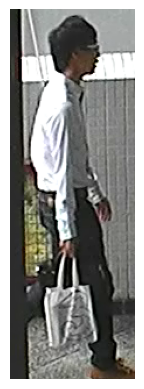

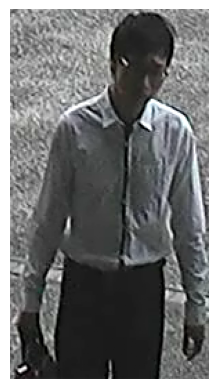

In [14]:
# from re import X
ind=200
print(y_train[ind],X_train[ind][0],X_train[ind][1])
display_image(X_train[ind][0])
display_image(X_train[ind][1])

In [15]:
val_data2=train_data.iloc[int(len(train_data)*0.8):]
X_val2,y_val2=[],[]
for i in range(len(val_data2)):
    img1='/kaggle/input/cuhk03/archive/images_labeled/'+val_data2.iloc[i,1]
    img2='/kaggle/input/cuhk03/archive/images_labeled/'+val_data2.iloc[i,2]
    if img1!=img2:
      X_val2.append([img1,img2])
      y_val2.append(val_data2.iloc[i,3])
print(len(X_val2),len(y_val2))
val_dataset2 = SiameseDataset(X_val2,y_val2, transform=transform)
val_dataloader2 = DataLoader(val_dataset2, batch_size=32, shuffle=True, num_workers=4)
print(len(val_dataloader2))

12599 12599
394


#Model Preparation

In [16]:
# class Contrastive_loss_fn(nn.Module):
#     def __init__(self, margin):
#         super(Contrastive_loss_fn, self).__init__()
#         self.margin = torch.tensor(margin, device='cuda') # Specify device for margin

#     def forward(self,output1,output2,label):
#         euclidean_distance=F.pairwise_distance(output1,output2,keepdim=True)
#         loss_contrastive = torch.mean((label)*torch.pow(euclidean_distance, 2) +
#                                      (1-label)*torch.pow(torch.clamp(euclidean_distance, min=self.margin), 2))
#         return loss_contrastive

class Contrastive_loss_fn(nn.Module):
    def __init__(self, margin):
        super(Contrastive_loss_fn, self).__init__()
        self.margin = torch.tensor(margin, device='cuda')

    def forward(self, output1, output2, label):
        cosine_sim = F.cosine_similarity(output1, output2)
        cosine_dist = 1.0-cosine_sim
        loss_contrastive = torch.mean((label) * torch.pow(cosine_dist, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - cosine_dist, min=0.0), 2))
        return loss_contrastive


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(batch_size, -1, width * height) # 2048x49
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        return out



class SiameseNetwork(nn.Module):
    def __init__(self,emb_dim,model):
        super(SiameseNetwork,self).__init__()
        self.encoder_model=model
        self.emb_dim=emb_dim
        self.classifier=nn.Linear(in_features=512,out_features=emb_dim)
        self.relu=nn.ReLU()
    def encode_one_image(self,x):
      x=self.encoder_model.encode_image(x)
      x=self.classifier(x.float())
      x=self.relu(x)
      return x
    def forward(self,input1,input2):
        output1=self.encode_one_image(input1)
        output2=self.encode_one_image(input2)
        return output1,output2




In [17]:
# Initialize the Siamese Network
criterion = Contrastive_loss_fn(margin=1)
optimizer = optim.SGD(model.parameters(), lr=0.00035, momentum=0.9) #lr=0.00035

model=SiameseNetwork(1024,model).to(device)
model=model.to(device)

In [18]:
# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze text model (not necessary since we are not using it in image-only tasks)
for param in model.encoder_model.transformer.parameters():
    param.requires_grad = False

# Unfreeze the higher layers of the image model
for name, param in model.encoder_model.visual.named_parameters():
    # Unfreeze only the higher layers (e.g., last N layers)
    if "block" in name and int(name.split(".")[2]) >= len(model.encoder_model.visual.transformer.resblocks) // 2:
        param.requires_grad = True

# Fine-tune the projection layer (classifier in SiameseNetwork)
for param in model.classifier.parameters():
    param.requires_grad = True


In [19]:
cnt=0;total=0
for i in model.parameters():
  if i.requires_grad:cnt+=1
  total+=1

print(f'% parameters trained= {cnt*100/total}')

% parameters trained= 24.342105263157894


In [20]:
for name, param in model.encoder_model.visual.named_parameters():
    # Unfreeze only the higher layers (e.g., last N layers)

    try:
      if "block" in name and int(name.split(".")[2]) >= len(model.encoder_model.visual.transformer.resblocks) // 2:
          param.requires_grad = True
    except:
      print(name.split("."))

tensor(0.)


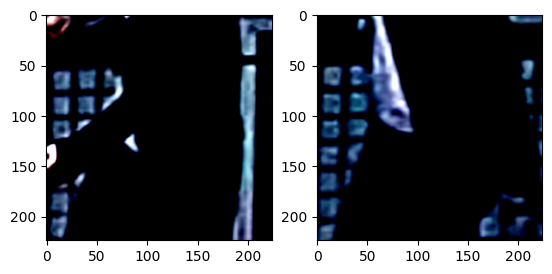

In [21]:
for i,j,l in dataloader:
  #displaying both images
  ind=4
  plt.subplot(1,2,1)
  plt.imshow(i[ind].permute(1,2,0))
  plt.subplot(1,2,2)
  plt.imshow(j[ind].permute(1,2,0))
  print(l[0])
  break

In [22]:
def test(dataloader,model,criterion):   #Provide test dataloader here
  with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for i, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            cosine_sim = F.cosine_similarity(output1, output2)
            cosine_dist = 1.0-cosine_sim
            pred=(cosine_dist<=1).float()
            num_correct = (pred == label).sum().item()
            total_correct += num_correct
            loss = criterion(output1, output2, label)
            total_loss += loss.item()
        print(f'validation_loss:{total_loss/len(dataloader)} validation_acuracy:{total_correct*100/len(test_data)}')


In [23]:
def validate(dataloader,model,criterion):   #Provide test dataloader here
  with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for i, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            cosine_sim = F.cosine_similarity(output1, output2)
            cosine_dist = 1.0-cosine_sim
            pred=(cosine_dist<=1).float()
            num_correct = (pred == label).sum().item()
            total_correct += num_correct
            loss = criterion(output1, output2, label)
            total_loss += loss.item()
        print(f'validation_loss:{total_loss/len(dataloader)} validation_acuracy:{total_correct*100/len(val_data)}')



def Train_one_epoch(epochs,dataloader,model,criterion):
    for no in range(epochs):
        total_loss = 0

        total_correct = 0
        for i, (img1, img2, label) in enumerate(dataloader):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)

            cosine_sim = F.cosine_similarity(output1, output2)
            cosine_dist = 1.0-cosine_sim
            pred=(cosine_dist<=1).float()
            num_correct = (pred == label).sum().item()
            total_correct+=num_correct

            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
            if i % 50 == 0:
              print(f"batch {i+1}, Iteration {i}: Loss = {loss.item()} continuous_acc: {total_correct*100/(32*(i+1))}")
            if i%400==0 and i!=0:
              validate(val_dataloader,model,criterion)
        print(f"Epoch avg Loss = {total_loss/len(dataloader)}")
        print(f"Epoch avg acc = {total_correct*100/len(train_data)}")

Train_one_epoch(5,dataloader,model,criterion)

batch 1, Iteration 0: Loss = 0.25277280807495117 continuous_acc: 68.75
batch 51, Iteration 50: Loss = 0.21664565801620483 continuous_acc: 46.26225490196079
batch 101, Iteration 100: Loss = 0.18335667252540588 continuous_acc: 45.60643564356435
batch 151, Iteration 150: Loss = 0.17787805199623108 continuous_acc: 45.46771523178808
batch 201, Iteration 200: Loss = 0.16619087755680084 continuous_acc: 45.25808457711443
batch 251, Iteration 250: Loss = 0.19626176357269287 continuous_acc: 44.721115537848604
batch 301, Iteration 300: Loss = 0.13649879395961761 continuous_acc: 44.61171096345515
batch 351, Iteration 350: Loss = 0.1548461616039276 continuous_acc: 44.60470085470085
batch 401, Iteration 400: Loss = 0.1666782647371292 continuous_acc: 44.4357855361596
validation_loss:0.14016126766048295 validation_acuracy:40.780658316341395
batch 451, Iteration 450: Loss = 0.14710025489330292 continuous_acc: 44.41518847006652
batch 501, Iteration 500: Loss = 0.13614284992218018 continuous_acc: 44.3799

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PRID/clip_model_parameters.pth')   #Personal

In [28]:
model.load_state_dict(torch.load('/content/drive/MyDrive/PRID/clip_model_parameters.pth'))

<ipython-input-28-18ef09878c61>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/PRID/clip_model_parameters.pth'))


<All keys matched successfully>

In [29]:
test(test_dataloader,model,criterion)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


validation_loss:0.0656619307769817 validation_acuracy:41.394779771615006


In [30]:
def validate_on_threshold(dataloader,model,criterion,th=1):   #Provide test dataloader here
  with torch.no_grad():
        total_loss = 0
        total_correct = 0
        total_image = (len(dataloader)-1)*32
        for i, (img1, img2, label) in enumerate(dataloader):
            if i==len(dataloader)-1:
              total_image += len(label)
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            cosine_sim = F.cosine_similarity(output1, output2)
            cosine_dist = 1.0-cosine_sim
            pred=(cosine_dist<=th).float()
            num_correct = (pred == label).sum().item()
            total_correct += num_correct
            loss = criterion(output1, output2, label)
            total_loss += loss.item()
        print(f'loss:{total_loss/len(dataloader)} acuracy:{total_correct*100/total_image}')

In [31]:
print("test_dataset: ")
validate_on_threshold(test_dataloader,model,criterion,0.5)
print("validation_dataset2: ")
validate_on_threshold(val_dataloader2,model,criterion,0.5)
print("validation_dataset: ")
validate_on_threshold(val_dataloader,model,criterion,0.5)

test_dataset: 
loss:0.0656475332350685 acuracy:94.32947281817607
validation_dataset2: 
loss:0.05791263368812763 acuracy:95.72188268910232
validation_dataset: 
loss:0.06392751133652648 acuracy:94.54487789406915


In [58]:
print("train_dataset: ")
validate_on_threshold(dataloader,model,criterion,0.5)

train_dataset: 


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


loss:0.0564073266894973 acuracy:95.95845706753903


In [55]:
model.eval()

imgs=[
    '/content/0002_c1s1_000801_01.jpg',
    '/content/0002_c1s2_050821_02.jpg',
    '/content/0007_c1s6_028546_04.jpg',
    '/content/0007_c3s3_077419_03.jpg',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_003_2_08.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_003_2_10.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_008_2_09.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_008_1_05.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_009_2_06.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_009_1_01.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_004_2_06.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_004_1_01.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_005_2_06.png',
  # '/kaggle/input/cuhk03/archive/images_labeled/1_005_1_02.png'
  ]

images=[transform(Image.open(i).convert("RGB")) for i in imgs]
image_input = torch.tensor(np.stack(images)).to(device)

outputs=[]
with torch.no_grad():
  for i in range(len(image_input)):
    outputs.append(model.encode_one_image(image_input[i].unsqueeze(0)))

  # o1,o2=Siamese_model(image_input[0].unsqueeze(0),image_input[1].unsqueeze(0))
similar_images=[]
for i in range(len(imgs)):
  temp=[]
  for j in range(len(imgs)):
    # temp.append(F.pairwise_distance(outputs[i],outputs[j]).item())
      cosine_sim = F.cosine_similarity(outputs[i], outputs[j])
      cosine_dist = 1.0-cosine_sim
      temp.append(cosine_dist.item())
  similar_images.append(temp)
similar_images
# distance=F.pairwise_distance(o1,o2)

[[-1.1920928955078125e-07,
  0.10616326332092285,
  0.7731264233589172,
  0.8725128173828125],
 [0.10616326332092285, 0.0, 0.7854501605033875, 0.8851039409637451],
 [0.7731264233589172, 0.7854501605033875, 0.0, 0.22817373275756836],
 [0.8725128173828125,
  0.8851039409637451,
  0.22817373275756836,
  -1.1920928955078125e-07]]

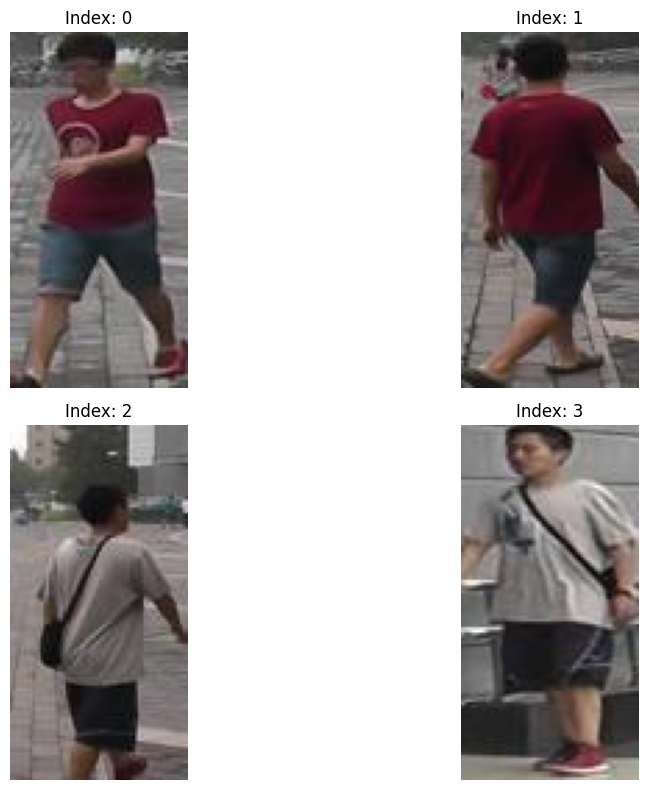

In [56]:
num_cols = 2  # Number of columns
num_rows = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Adjust figsize as needed

# Iterate through images and display them
for i, img_path in enumerate(imgs):
    row = i // num_cols
    col = i % num_cols
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Index: {i}")
    axes[row, col].axis('off')  # Hide axes

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

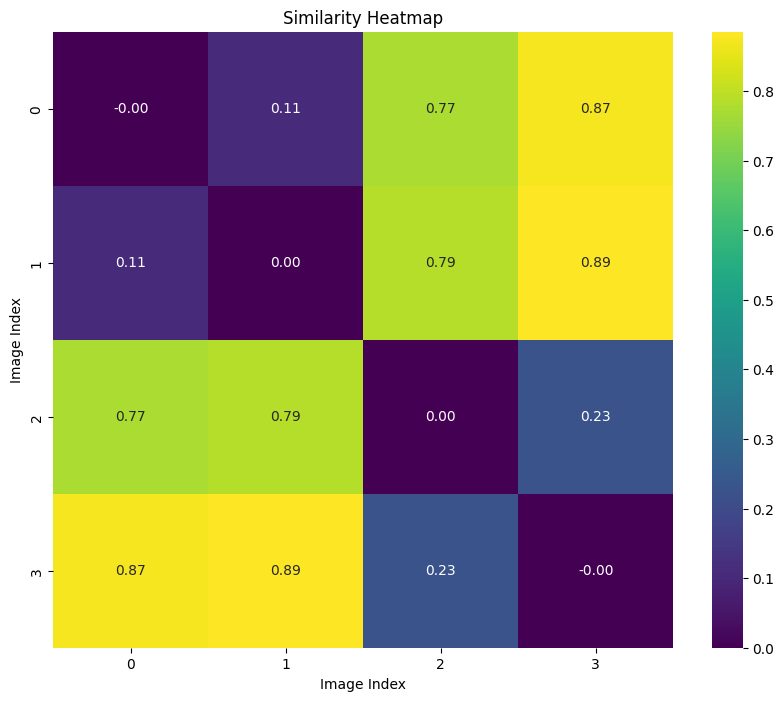

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'similar_images' is your list of lists
plt.figure(figsize=(10, 8))
sns.heatmap(similar_images, annot=True, cmap='viridis', fmt=".2f")
plt.title("Similarity Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()